In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar.gz


In [4]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-d48c3acd
# github.com:22 SSH-2.0-babeld-d48c3acd
# github.com:22 SSH-2.0-babeld-d48c3acd


In [5]:
!ssh-agent /bin/bash

bash: cannot set terminal process group (139): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [6]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images=1000):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    return X, y
  def build_model(self, n_components, model_filename, log_filename, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=self.all_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, batch_size, n_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(self.model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(self.model_filename)
    train_log = pd.read_csv(self.log_filename)
    data_dict = {'Date':datetime.now(), 'Run_Number':i+1, 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(self.log_filename, index=False)
  def predict_model(self, X, y, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(self.model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [35]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)



100%|██████████| 56709/56709 [00:00<00:00, 2853481.28it/s]


In [36]:
print(len(cat_dir), len(face_dir))
X_0, y_0 = decoder_model.load_data(cat_dir, face_dir, 2)

9908 46801


In [38]:
decoder_model.all_dim

2

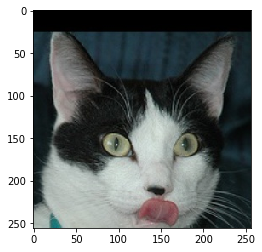

5000


In [0]:
PIC = np.random.choice(5000)
plt.imshow(decoder_model.imgs[PIC])
plt.show()
print(len(decoder_model.imgs))

In [11]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [39]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20

decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN)

In [0]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 1000 imgs and 20 epochs per pull. In order to
#match num of imgs seen by network to his, I need to pull from the 
#dataset 3,538 times.

N_IMAGES = 1000
N_LOOPS = 10
for i in range(N_LOOPS):
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, BATCH_SIZE, N_EPOCHS)
  message = 'trained %d of %d epochs' % (N_EPOCHS*(i+1), N_EPOCHS*N_LOOPS)
  message = message.replace(' ', '_')
  #save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))


1486_017.jpg
Training Batch # 3
Train on 21 samples, validate on 6 samples
Epoch 1/20
21/21 [==============================] - 1s 29ms/step - loss: 0.0682 - val_loss: 0.0639
Epoch 2/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0634
Epoch 3/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0627
Epoch 4/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0621
Epoch 5/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0616
Epoch 6/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0612
Epoch 7/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0609
Epoch 8/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0608
Epoch 9/20
21/21 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0607
Epoch 10/20
21/21 [=======================

In [8]:
os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, batch_size=BATCH_SIZE)

NameError: ignored

2768


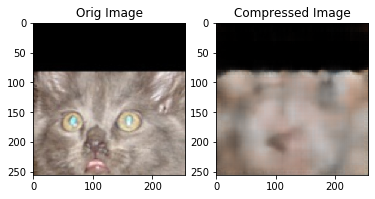

In [0]:
PIC = np.random.choice(5000)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
save_to_git('switched_to_batch_image_loading')

Already up to date.


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


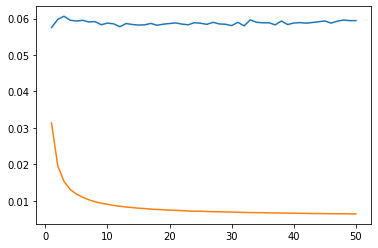

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()